In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install keras_unet
from keras_unet.models import satellite_unet
import cv2
import json
import os
import matplotlib.pyplot as plt
import numpy as np
 
trainlib = '/content/drive/My Drive/Midterm/data/images'
trainmasklib = '/content/drive/My Drive/Midterm/data/masks'
 
testlib = '/content/drive/My Drive/Midterm/data_test/images'
testmasklib = '/content/drive/My Drive/Midterm/data_test/masks'
 
save_model_location = '/content/drive/My Drive/Midterm/saved'

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [ ]:
# import cv2
# import json
# # change testlib to trainlib for train mask
# listimg = os.listdir(testlib)
# for item in listimg:
#   imgjson = item[:-3] + 'json'
#   with open(os.path.join('/content/gdrive/My Drive/Midterm/Ano Json',imgjson)) as json_file:
#     data = json.load(json_file)
#   mask = []
#   for i in data.get('shapes'):
#     mask.append(i.get('points'))
#   imit = cv2.imread(os.path.join(testlib, item))
#   temp = np.zeros([imit.shape[0],imit.shape[1]])
#   for j in mask:
#     temp = cv2.fillPoly(temp, pts =[np.array(j).astype(int)], color=(255,255,255))
#   cv2.imwrite(os.path.join(testmasklib, item),temp)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_gen_args = dict(rescale = 1./255,
                    # featurewise_center=True,
                    #  featurewise_std_normalization=True,
                    rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    validation_split=0.2)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
# Provide the same seed and keyword arguments to the fit and flow methods
 
# image_datagen.fit(images, augment=True, seed = 1)
# mask_datagen.fit(masks, augment=True, seed=1)
image_generator = image_datagen.flow_from_directory(
    trainlib,
    target_size=(512, 512),
    class_mode=None,
    batch_size=4,
    seed=1)
mask_generator = mask_datagen.flow_from_directory(
    trainmasklib,
    target_size=(512, 512),
    class_mode=None,
    batch_size=4,
    seed=1)
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

Found 40 images belonging to 1 classes.
Found 40 images belonging to 1 classes.


In [4]:
from tensorflow.keras import backend as K
 # calculate Metric
def mean_iou(y_true, y_pred, smooth=1):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32') # .5 is the threshold
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + K.epsilon()) / (union + K.epsilon()), axis=0)


In [13]:
model2 = satellite_unet(input_shape=(512, 512, 3))
model2.compile('adam','binary_crossentropy',metrics=[mean_iou])

In [5]:
# train model
model2.fit(
        train_generator,
        steps_per_epoch=1000,
        epochs=5
)

Epoch 1/5
1000/1000 [==============================] - 652s 652ms/step - loss: 0.2415 - mean_iou: 0.7931
Epoch 2/5
1000/1000 [==============================] - 638s 638ms/step - loss: 0.1155 - mean_iou: 1.1735
Epoch 3/5
1000/1000 [==============================] - 636s 636ms/step - loss: 0.0616 - mean_iou: 1.3178
Epoch 4/5
1000/1000 [==============================] - 639s 639ms/step - loss: 0.0441 - mean_iou: 1.3672
Epoch 5/5
1000/1000 [==============================] - 637s 637ms/step - loss: 0.0439 - mean_iou: 1.3693


In [9]:
model2.save(os.path.join(save_model_location, 'MidModel'), overwrite=False)
model2.save_weights(os.path.join(save_model_location, 'MidModel.h5'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Midterm/saved/MidModel/assets


In [14]:
# Load Weights
model2.load_weights(os.path.join(save_model_location, 'MidModel.h5'))

In [19]:
imgtest = cv2.imread('Screenshot_2.png')
imgtest = cv2.resize(imgtest,(512,512))
 
imgtest = imgtest.astype(np.float32)/255.0
 
imgtest=imgtest[None,...]
y= model2.predict(imgtest)
y=y.reshape(512,512)
 
y = np.where(y>=0.2,1,0)
y = y * 255
y = y.astype(np.uint8)




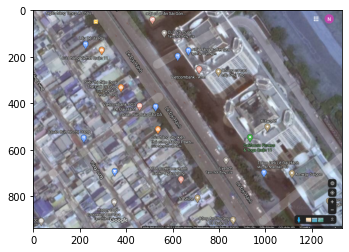

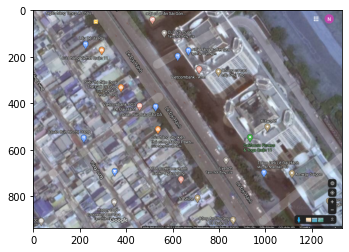

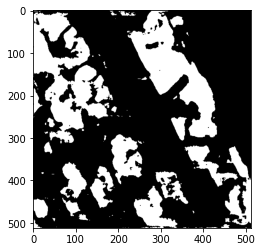

In [20]:
testmm = cv2.imread(os.path.join('Screenshot_2.png'))
plt.imshow(testmm)
plt.show()
imgtesttrue = cv2.imread(os.path.join('Screenshot_2.png'))
plt.imshow(imgtesttrue)
plt.show()
plt.imshow(y,cmap = 'gray')
plt.show()